# IQNx4: Chapter 3: Autoregressive Evaluation

## 3.1: Imports and Configurations

In [1]:
import numpy as np
import pandas as pd

# import scipy as sp; import scipy.stats as st
import torch
import torch.nn as nn

print(f"using torch version {torch.__version__}")
# use numba's just-in-time compiler to speed things up
# from numba import njit
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import matplotlib as mp

print("matplotlib version= ", mp.__version__)

import matplotlib.pyplot as plt

# reset matplotlib stle/parameters
# reset matplotlib parameters to their defaults
# plt.style.use('seaborn-deep')
# mp.rcParams['agg.path.chunksize'] = 10000
font_legend = 15
font_axes = 15
# %matplotlib inline
import sys
import os

# from IPython.display import Image, display
# from importlib import import_module
# import plotly
try:
    import optuna

    print(f"using (optional) optuna version {optuna.__version__}")
except Exception:
    print("optuna is only used for hyperparameter tuning, not critical!")
    pass
import argparse
import time

# import sympy as sy
# import ipywidgets as wid;

# update fonts
font = {"family": "serif", "size": 10}
mp.rc("font", **font)

# set usetex = False if LaTex is not
# available on your system or if the
# rendering is too slow
mp.rcParams.update({"text.usetex": True})
# plt.rcParams['text.usetex'] = True
mp.rcParams["text.latex.preamble"] = [r"\usepackage{amsmath}"]  # for \text command


# set a seed to ensure reproducibility
# seed = 128
# rnd  = np.random.RandomState(seed)
# sometimes jupyter doesnt initialize MathJax automatically for latex, so do this:

try:
    IQN_BASE = os.environ["IQN_BASE"]
    print("BASE directoy properly set = ", IQN_BASE)
    utils_dir = os.path.join(IQN_BASE, 'utils/')
    sys.path.append(utils_dir)
    import utils

    # usually its not recommended to import everything from a module, but we know
    # whats in it so its fine
    # from utils import *
    print("DATA directory also properly set, in %s" % os.environ["DATA_DIR"])
except Exception:
    # IQN_BASE=os.getcwd()
    print(
        """\nBASE directory not properly set. Read repo README.    If you need a function from utils, use the decorator below, or add utils to sys.path\n
    You can also do 
    os.environ['IQN_BASE']=<ABSOLUTE PATH FOR THE IQN REPO>
    or
    os.environ['IQN_BASE']=os.getcwd()"""
    )
    pass


IQN_BASE = os.environ["IQN_BASE"]
print("BASE directoy properly set = ", IQN_BASE)
utils_dir = os.path.join(IQN_BASE, "utils/")
sys.path.append(utils_dir)
# usually its not recommended to import everything from a module, but we know
# whats in it so its fine

# or use joblib for caching on disk
from joblib import Memory


################################### CONFIGURATIONS ###################################
DATA_DIR = os.environ["DATA_DIR"]
print(f"using DATA_DIR={DATA_DIR}")
JUPYTER = False
use_subsample = False
# use_subsample=True
if use_subsample:
    SUBSAMPLE = int(
        1e5
    )  # subsample use for development - in production use whole dataset
else:
    SUBSAMPLE = None

memory = Memory(DATA_DIR)


###############################################################################################
y_label_dict = {
    "RecoDatapT": "$p(p_T)$" + " [ GeV" + "$^{-1} $" + "]",
    "RecoDataeta": "$p(\eta)$",
    "RecoDataphi": "$p(\phi)$",
    "RecoDatam": "$p(m)$" + " [ GeV" + "$^{-1} $" + "]",
}

loss_y_label_dict = {
    "RecoDatapT": "$p_T^{reco}$",
    "RecoDataeta": "$\eta^{reco}$",
    "RecoDataphi": "$\phi^{reco}$",
    "RecoDatam": "$m^{reco}$",
}


################################### SET DATA CONFIGURATIONS ###################################
X = ["genDatapT", "genDataeta", "genDataphi", "genDatam", "tau"]

# set order of training:
# pT_first: pT->>m->eta->phi
# m_first: m->pT->eta->phi


ORDER = "m_First"

if ORDER == "m_First":
    FIELDS = {
        "RecoDatam": {
            "inputs": X,
            "xlabel": r"$m$ (GeV)",
            "ylabel": "$m^{reco}$",
            "xmin": 0,
            "xmax": 25,
        },
        "RecoDatapT": {
            "inputs": ["RecoDatam"] + X,
            "xlabel": r"$p_T$ (GeV)",
            "ylabel": "$p_T^{reco}$",
            "xmin": 20,
            "xmax": 80,
        },
        "RecoDataeta": {
            "inputs": ["RecoDatam", "RecoDatapT"] + X,
            "xlabel": r"$\eta$",
            "ylabel": "$\eta^{reco}$",
            "xmin": -5,
            "xmax": 5,
        },
        "RecoDataphi": {
            "inputs": ["RecoDatam", "RecoDatapT", "RecoDataeta"] + X,
            "xlabel": r"$\phi$",
            "ylabel": "$\phi^{reco}$",
            "xmin": -3.2,
            "xmax": 3.2,
        },
    }


# Load and explore raw (unscaled) dataframes


all_variable_cols = [
    "genDatapT",
    "genDataeta",
    "genDataphi",
    "genDatam",
    "RecoDatapT",
    "RecoDataeta",
    "RecoDataphi",
    "RecoDatam",
]
all_cols = [
    "genDatapT",
    "genDataeta",
    "genDataphi",
    "genDatam",
    "RecoDatapT",
    "RecoDataeta",
    "RecoDataphi",
    "RecoDatam",
    "tau",
]



using torch version 1.11.0.post2
matplotlib version=  3.5.3
using (optional) optuna version 3.0.0
BASE directoy properly set =  /home/ali/Desktop/Pulled_Github_Repositories/torchQN
using torch version 1.11.0.post2
matplotlib version=  3.5.3
using (optional) optuna version 3.0.0
BASE directoy properly set =  /home/ali/Desktop/Pulled_Github_Repositories/torchQN
DATA directory also properly set, in /home/ali/Desktop/Pulled_Github_Repositories/IQN_HEP/Davidson/data
DATA directory also properly set, in /home/ali/Desktop/Pulled_Github_Repositories/IQN_HEP/Davidson/data
BASE directoy properly set =  /home/ali/Desktop/Pulled_Github_Repositories/torchQN
using DATA_DIR=/home/ali/Desktop/Pulled_Github_Repositories/IQN_HEP/Davidson/data


/tmp/ipykernel_4164329/2263036294.py:54: MatplotlibDeprecationWarning: Support for setting an rcParam that expects a str value to a non-str value is deprecated since 3.5 and support will be removed two minor releases later.
  mp.rcParams["text.latex.preamble"] = [r"\usepackage{amsmath}"]  # for \text command


## 3.2: Needed Functions

In [2]:
target = "RecoDatam"
source = FIELDS[target]
features = source["inputs"]
print("Training Features:\n", features)
print("\nTarget = ", target)
AUTOREGRESSIVE_DIST_NAME = "AUTOREGRESSIVE_m_Prime.csv"
print("USING NEW DATASET\n")
######################################
USE_BRADEN_SCALING = False
#####################################
################################### CONFIGURATIONS ###################################

JUPYTER = True
use_subsample = False
# use_subsample = True
if use_subsample:
    SUBSAMPLE = int(
        1e5
    )  # subsample use for development - in production use whole dataset
else:
    SUBSAMPLE = None

########################################################################################

Training Features:
 ['genDatapT', 'genDataeta', 'genDataphi', 'genDatam', 'tau']

Target =  RecoDatam
USING NEW DATASET



In [3]:
################################## Load unscaled dataframes ###################################
@memory.cache
def load_raw_data():
    """Dont use AUTOREGRESSIVE_DIST_NAME for training of any variable. 
    For mass evaluation: dont use AUTOREGRESSIVE_DIST_NAME. For pT evaluation use AUTOREGRESSIVE_DIST_NAME 
    as the distribution predicted by mass, etc.  """
    print(f"\nSUBSAMPLE = {SUBSAMPLE}\n")
    raw_train_data = pd.read_csv(
        os.path.join(DATA_DIR, "train_data_10M_2.csv"),
        usecols=all_cols,
        nrows=SUBSAMPLE,
    )



    raw_valid_data = pd.read_csv(
        os.path.join(DATA_DIR, "validation_data_10M_2.csv"),
        usecols=all_cols,
        nrows=SUBSAMPLE,
    )
    

    
    raw_test_data = pd.read_csv(
    os.path.join(DATA_DIR, "test_data_10M_2.csv"), 
    usecols=all_cols, 
    nrows=SUBSAMPLE
    )

    print("\n RAW TRAIN DATA\n")
    print(raw_train_data.shape)
    raw_train_data.describe()  # unscaled
    print("\n RAW TEST DATA\n")
    print(raw_test_data.shape)
    raw_test_data.describe()  # unscaled

    return raw_train_data, raw_test_data, raw_valid_data


########## Generate scaled data###############
# scaled_train_data = L_scale_df(raw_train_data, title='scaled_train_data_10M_2.csv',
#                              save=True)
# print('\n\n')
# scaled_test_data = L_scale_df(raw_test_data,  title='scaled_test_data_10M_2.csv',
#                             save=True)
# print('\n\n')

# scaled_valid_data = L_scale_df(raw_valid_data,  title='scaled_valid_data_10M_2.csv',
#                             save=True)

# explore_data(df=scaled_train_data, title='Braden Kronheim-L-scaled Dataframe', scaled=True)

################ Load scaled data##############
@utils.time_type_of_func(tuning_or_training="loading")
# @memory.cache
def load_scaled_dataframes():
    print("SCALED TRAIN DATA")
    scaled_train_data = pd.read_csv(
        os.path.join(DATA_DIR, "scaled_train_data_10M_2.csv"),
        usecols=all_cols,
        nrows=SUBSAMPLE,
    )

    print("TRAINING FEATURES\n", scaled_train_data.head())

    scaled_test_data = pd.read_csv(
        os.path.join(DATA_DIR, "scaled_test_data_10M_2.csv"),
        usecols=all_cols,
        nrows=SUBSAMPLE,
    )

    scaled_valid_data = pd.read_csv(
        os.path.join(DATA_DIR, "scaled_valid_data_10M_2.csv"),
        usecols=all_cols,
        nrows=SUBSAMPLE,
    )
    return scaled_train_data, scaled_test_data, scaled_valid_data


#######################################
#
# # print('\nTESTING FEATURES\n', scaled_test_data.head())

# print('\ntrain set shape:',  scaled_train_data.shape)
# print('\ntest set shape:  ', scaled_test_data.shape)
# # print('validation set shape:', valid_data.shape)
# @memory.cache
def get_train_scale_dict(USE_BRADEN_SCALING):
    if USE_BRADEN_SCALING==True:
        TRAIN_SCALE_DICT = utils.get_scaling_info(scaled_train_data)
        print("BRADEN SCALING DICTIONARY")
        print(TRAIN_SCALE_DICT)
        print("\n\n")
        # TEST_SCALE_DICT = get_scaling_info(scaled_test_data)
        # print(TEST_SCALE_DICT)
    else:
        print("NORMAL UNSCALED DICTIONARY")
        TRAIN_SCALE_DICT = utils.get_scaling_info(raw_train_data)
        print(TRAIN_SCALE_DICT)
        print("\n\n")
        # TEST_SCALE_DICT = get_scaling_info(scaled_test_data)
        # print(TEST_SCALE_DICT)
    return TRAIN_SCALE_DICT


################################ SPLIT###########
# @memory.cache
def T(variable, scaled_df):
    if variable == "pT":
        L_pT_gen = scaled_df["genDatapT"]
        L_pT_reco = scaled_df["RecoDatapT"]
        target = (L_pT_reco + 10) / (L_pT_gen + 10)
    if variable == "eta":
        L_eta_gen = scaled_df["genDataeta"]
        L_eta_reco = scaled_df["RecoDataeta"]
        target = (L_eta_reco + 10) / (L_eta_gen + 10)
    if variable == "phi":
        L_phi_gen = scaled_df["genDataphi"]
        L_phi_reco = scaled_df["RecoDataphi"]
        target = (L_phi_reco + 10) / (L_phi_gen + 10)
    if variable == "m":
        L_m_gen = scaled_df["genDatam"]
        L_m_reco = scaled_df["RecoDatam"]
        target = (L_m_reco + 10) / (L_m_gen + 10)

    return target


# @memory.cache
def split_t_x(df, target, input_features):
    """Get teh target as the ratio, according to the T equation"""

    if target == "RecoDatam":
        t = T("m", scaled_df=scaled_train_data)
    if target == "RecoDatapT":
        t = T("pT", scaled_df=scaled_train_data)
    if target == "RecoDataeta":
        t = T("eta", scaled_df=scaled_train_data)
    if target == "RecoDataphi":
        t = T("phi", scaled_df=scaled_train_data)
    x = np.array(df[input_features])
    return np.array(t), x


# @memory.cache
def split_t_x_test(df, target, input_features):
    """Get teh target as the ratio, according to the T equation"""

    if target == "RecoDatam":
        t = T("m", scaled_df=scaled_test_data)
    if target == "RecoDatapT":
        t = T("pT", scaled_df=scaled_test_data)
    if target == "RecoDataeta":
        t = T("eta", scaled_df=scaled_test_data)
    if target == "RecoDataphi":
        t = T("phi", scaled_df=scaled_test_data)
    x = np.array(df[input_features])
    return np.array(t), x


#########################################################################
# @memory.cache
def normal_split_t_x(df, target, input_features):
    # change from pandas dataframe format to a numpy
    # array of the specified types
    # t = np.array(df[target])
    t = np.array(df[target])
    x = np.array(df[input_features])
    return t, x


################ Apply Z scaling############
def z(x):
    eps = 1e-20
    return (x - np.mean(x)) / (np.std(x) + eps)


def z_inverse(xprime, x):
    return xprime * np.std(x) + np.mean(x)


# @memory.cache
def z2(x, mean, std):
    """
    Args:
        x ([type]): [description]
        mean ([type]): [description]
        std ([type]): [description]

    Returns:
        [type]: [description]
    """
    eps = 1e-20
    scaled = (x - mean) / (std + eps)
    return np.array(scaled, dtype=np.float64)


def z_inverse(xprime, x):
    unscaled = xprime * np.std(x) + np.mean(x)
    return np.array(unscaled, dtype=np.float64)


# @memory.cache
def z_inverse2(xprime, train_mean, train_std):
    """mean original train mean, std: original. Probably not needed"""
    return xprime * train_std + train_mean


# @memory.cache
def apply_z_to_features(TRAIN_SCALE_DICT, train_x, test_x, valid_x):
    """TO ensure this z scaling is only applied once to the training features, we use a generator.
    This doesn't change the shapes of anything, just applies z to all the feature columns other than tau"""
    NFEATURES = train_x.shape[1]
    for i in range(NFEATURES - 1):
        variable = list(TRAIN_SCALE_DICT)[i]
        train_mean = float(TRAIN_SCALE_DICT[variable]["mean"])
        train_std = float(TRAIN_SCALE_DICT[variable]["std"])
        train_x[:, i] = z2(train_x[:, i], mean=train_mean, std=train_std)
        test_x[:, i] = z2(test_x[:, i], mean=train_mean, std=train_std)
        valid_x[:, i] = z2(valid_x[:, i], mean=train_mean, std=train_std)
    yield train_x
    yield test_x
    yield valid_x


# @memory.cache
def apply_z_to_targets(train_t, test_t, valid_t):
    train_mean = np.mean(train_t)
    train_std = np.std(train_t)
    train_t_ = z2(train_t, mean=train_mean, std=train_std)
    test_t_ = z2(test_t, mean=train_mean, std=train_std)
    valid_t_ = z2(valid_t, mean=train_mean, std=train_std)

    yield train_t_
    yield test_t_
    yield valid_t_


# @utils.debug
def save_model(model, PATH):
    print(model)
    torch.save(model.state_dict(), PATH)
    print("\ntrained model dictionary saved in %s" % PATH)


# @utils.debug
def load_model(PATH, PARAMS):
    # n_layers = int(BEST_PARAMS["n_layers"])
    # hidden_size = int(BEST_PARAMS["hidden_size"])
    # dropout = float(BEST_PARAMS["dropout"])
    # optimizer_name = BEST_PARAMS["optimizer_name"].to_string().split()[1]
    # learning_rate =  float(BEST_PARAMS["learning_rate"])
    # batch_size = int(BEST_PARAMS["batch_size"])
    model = utils.RegularizedRegressionModel(
        nfeatures=NFEATURES,
        ntargets=1,
        nlayers=PARAMS["n_layers"],
        hidden_size=PARAMS["hidden_size"],
        dropout_1=PARAMS["dropout_1"],
        dropout_2=PARAMS["dropout_2"],
        activation=PARAMS["activation"],
    )
    model.load_state_dict(torch.load(PATH))
    # OR
    # model=torch.load(PATH)#BUT HERE IT WILL BE A DICT (CANT BE EVALUATED RIGHT AWAY) DISCOURAGED! Also, use dictionary ".pth" which has both the model state dict and the PARAMS dict
    model.eval()
    print(model)
    return model


# @memory.cache
def simple_eval(model, test_x_z_scaled):
    model.eval()
    # evaluate on the scaled features
    valid_x_tensor = torch.from_numpy(test_x_z_scaled).float()
    # valid_x_tensor=torch.from_numpy(train_x).float()
    pred = model(valid_x_tensor)
    p = pred.detach().numpy()
    # if USE_BRADEN_SCALING:
    #     fig, ax = plt.subplots(1,1)
    #     label=FIELDS[target]['ylabel']
    #     ax.hist(p, label=f'Predicted post-z ratio for {label}', alpha=0.4, density=True)
    #     # orig_ratio = z(T('m', scaled_df=scaled_train_data))
    #     orig_ratio = z(T('m', scaled_df=scaled_test_data))
    #     print(orig_ratio[:5])
    #     ax.hist(orig_ratio, label = f'original post-z ratio for {label}', alpha=0.4,density=True)
    #     ax.grid()
    #     set_axes(ax, xlabel='predicted $T$')
    # print('predicted ratio shape: ', p.shape)
    return p

def get_previous_autoregressive_dist(AUTOREGRESSIVE_DIST_NAME):
        
    print(f'Test (evaluation) Data is Autoregressive, loading {AUTOREGRESSIVE_DIST_NAME}')
    eval_data = pd.read_csv(
        os.path.join(
            IQN_BASE,
            "JupyterBook",
            "Cluster",
            "EVALUATE",
            AUTOREGRESSIVE_DIST_NAME,
        )
    )
    return eval_data


# @memory.cache
def get_hist(label):
    """label could be "pT", "eta", "phi", "m" """
    predicted_label_counts, label_edges = np.histogram(
        JETS_DICT["Predicted_RecoData" + label]["dist"],
        range=JETS_DICT["Predicted_RecoData" + label]["range"],
        bins=bins,
    )
    real_label_counts, _ = np.histogram(
        JETS_DICT["Real_RecoData" + label]["dist"],
        range=JETS_DICT["Real_RecoData" + label]["range"],
        bins=bins,
    )
    label_edges = label_edges[1:] / 2 + label_edges[:-1] / 2

    return real_label_counts, predicted_label_counts, label_edges


# @memory.cache
def get_hist_simple(predicted_dist, target):
    
    range_ = (FIELDS[target]["xmin"], FIELDS[target]["xmax"])
    bins=50
    predicted_label_counts, label_edges = np.histogram(
        predicted_dist, range=range_, bins=bins
    )
    
    
    real_label_counts, _ = np.histogram(REAL_DIST, range=range_, bins=bins)
    label_edges = label_edges[1:] / 2 + label_edges[:-1] / 2
    return real_label_counts, predicted_label_counts, label_edges


# @memory.cache
def plot_one(
    target, real_edges, real_counts, predicted_counts, save_plot=False, PARAMS=None, JUPYTER=True
):
    fig, (ax1, ax2) = plt.subplots(
        2, 1, figsize=(3.5 * 3 / 2.5, 3.8), gridspec_kw={"height_ratios": [2, 0.5]}
    )
    ax1.step(
        real_edges, real_counts / norm_data, where="mid", color="k", linewidth=0.5
    )  # step real_count_pt
    ax1.step(
        real_edges,
        predicted_counts / norm_IQN,
        where="mid",
        color="#D7301F",
        linewidth=0.5,
    )  # step predicted_count_pt
    ax1.scatter(
        real_edges,
        real_counts / norm_data,
        label="reco",
        color="k",
        facecolors="none",
        marker="o",
        s=5,
        linewidth=0.5,
    )
    ax1.scatter(
        real_edges,
        predicted_counts / norm_IQN,
        label="predicted",
        color="#D7301F",
        marker="x",
        s=5,
        linewidth=0.5,
    )
    ax1.set_xlim(range_)
    ax1.set_ylim(0, max(predicted_counts / norm_IQN) * 1.1)
    ax1.set_ylabel("counts")
    ax1.set_xticklabels([])
    ax1.legend(loc="upper right")

    ratio = (predicted_counts / norm_IQN) / (real_counts / norm_data)
    ax2.scatter(
        real_edges, ratio, color="r", marker="x", s=5, linewidth=0.5
    )  # PREDICTED (IQN)/Reco (Data)
    ax2.scatter(
        real_edges,
        ratio / ratio,
        color="k",
        marker="o",
        facecolors="none",
        s=5,
        linewidth=0.5,
    )
    ax2.set_xlim(range_)
    ax2.set_xlabel(FIELDS[target]["xlabel"])
    ax2.set_ylabel(
        r"$\frac{\textnormal{predicted}}{\textnormal{reco}}$"
        #    , fontsize=10
    )
    ax2.set_ylim((YLIM))
    ax2.set_xlim(range_)
    ax2.set_yticklabels([0.8, 1.0, 1.2])
    if JUPYTER==True:
        plt.show()
    else:
        plt.tight_layout()
        fig.subplots_adjust(wspace=0.5, hspace=0.2)
        fig.subplots_adjust(wspace=0.0, hspace=0.1)
        plt.axis('off')

    # plt.gca().set_position([0, 0, 1, 1])
    if save_plot:
        plot_filename = utils.get_model_filename(target, PARAMS).split(".dict")[0] + ".png"
        plt.savefig(
            os.path.join(IQN_BASE, "JupyterBook", "Cluster", "EVALUATE", plot_filename)
        )

    
    # fig.show()
    # plt.show();
    # plt.axis("off")
    # plt.gca().set_position([0, 0, 1, 1])

In [4]:
#load data only once, and with caching!
raw_train_data, raw_test_data, raw_valid_data = load_raw_data()

# Load scaled data
# scaled_train_data, scaled_test_data, scaled_valid_data = load_scaled_dataframes()

## 3.3: Evaluate Mass

In [ ]:
# TODO: plot the loss curves (train and valid) of all 4 networks on the same plot,
# and with the learning rate plotted on the same plot but on a different y axis 
# (x axis being iteration, with marks indicating epochs)

target = "RecoDatam"
source = FIELDS[target]
features = source["inputs"]
print("Training Features:\n", features)
print("\nTarget = ", target)
AUTOREGRESSIVE_DIST_NAME = "AUTOREGRESSIVE_m_Prime.csv"
print("USING NEW DATASET\n")
######################################
USE_BRADEN_SCALING = False
#####################################
################################### CONFIGURATIONS ###################################

JUPYTER = True
use_subsample = False
# use_subsample = True
if use_subsample:
    SUBSAMPLE = int(
        1e5
    )  # subsample use for development - in production use whole dataset
else:
    SUBSAMPLE = None

########################################################################################
# Get targets and features
if USE_BRADEN_SCALING==True:
    print(f"spliting data for {target}")
    train_t, train_x = split_t_x(
        df=scaled_train_data, target=target, input_features=features
    )
    print("train_t shape = ", train_t.shape, "train_x shape = ", train_x.shape)
    print("\n Training features:\n")
    print(train_x)
    valid_t, valid_x = split_t_x(
        df=scaled_valid_data, target=target, input_features=features
    )
    print("valid_t shape = ", valid_t.shape, "valid_x shape = ", valid_x.shape)
    test_t, test_x = split_t_x(
        df=scaled_test_data, target=target, input_features=features
    )
    print("test_t shape = ", test_t.shape, "test_x shape = ", test_x.shape)

else:
    print(f"spliting data for {target}")
    train_t, train_x = normal_split_t_x(
        df=raw_train_data, target=target, input_features=features
    )
    print("train_t shape = ", train_t.shape, "train_x shape = ", train_x.shape)
    print("\n Training features:\n")
    print(train_x)
    valid_t, valid_x = normal_split_t_x(
        df=raw_valid_data, target=target, input_features=features
    )
    print("valid_t shape = ", valid_t.shape, "valid_x shape = ", valid_x.shape)
    test_t, test_x = normal_split_t_x(
        df=raw_test_data, target=target, input_features=features
    )
    print("test_t shape = ", test_t.shape, "test_x shape = ", test_x.shape)

print("no need to train_test_split since we already have the split dataframes")
print(valid_x.mean(axis=0), valid_x.std(axis=0))
print(train_x.mean(axis=0), train_x.std(axis=0))
print(valid_t.mean(), valid_t.std())
print(train_t.mean(), train_t.std())
######################################################

# Apply z scaling to features and targets
# to features

NFEATURES = train_x.shape[1]
TRAIN_SCALE_DICT = get_train_scale_dict(USE_BRADEN_SCALING)
# to features
apply_z_generator = apply_z_to_features(TRAIN_SCALE_DICT, train_x, test_x, valid_x)
train_x_z_scaled = next(apply_z_generator)
test_x_z_scaled = next(apply_z_generator)
valid_x_z_scaled = next(apply_z_generator)
print(valid_x_z_scaled.mean(axis=0), valid_x_z_scaled.std(axis=0))
print(train_x_z_scaled.mean(axis=0), train_x_z_scaled.std(axis=0))
# to targets
apply_z_to_targets_generator = apply_z_to_targets(train_t, test_t, valid_t)
train_t_z_scaled = next(apply_z_to_targets_generator)
test_t_z_scaled = next(apply_z_to_targets_generator)
valid_t_z_scaled = next(apply_z_to_targets_generator)
print(valid_t_z_scaled.mean(), valid_t_z_scaled.std())
print(train_t_z_scaled.mean(), train_t_z_scaled.std())

###########################################################
# Get the  parameters for this model and training
PARAMS_m = {
"n_layers": int(4),
"hidden_size": int(5),
"dropout_1": float(0.6),
"dropout_2": float(0.1),
"activation": "LeakyReLU",
    'optimizer_name':'Adam',
    'starting_learning_rate':float(0.5),
    'momentum':float(0.6),
    'batch_size':int(512),
    'n_iterations': int(5e5),
}

optimizer_name = PARAMS_m["optimizer_name"]
print(type(optimizer_name))
# optimizer_name = BEST_PARAMS["optimizer_name"].to_string().split()[1]
NITERATIONS = PARAMS_m["n_iterations"]
BATCHSIZE = PARAMS_m["batch_size"]
comment = ""

# N_epochs X N_train_examples = N_iterations X batch_size
N_epochs = (NITERATIONS * BATCHSIZE) / int(train_x.shape[0])
print(
    f"This model was trained for {NITERATIONS} iteration, which is  {N_epochs} epochs"
)

# 'Trained_IQNx4_%s_TUNED.dict' % target
filename_model = utils.get_model_filename(target, PARAMS_m)
# OR, if you know a model filename directly, you can also specify it, 
# BUT, if you pull a trained model explicitly, you have to make sure its parameters in the PARAMS dictionary above match
# Nominal one is 'Trained_IQNx4_RecoDatam_ 8_layer5_hiddenLeakyReLU_activation1024_batchsize300_Kiteration.dict', also in backup
# filename_model='Trained_IQNx4_RecoDatam_ 8_layer5_hiddenLeakyReLU_activation1024_batchsize300_Kiteration.dict'
# filename_model='Trained_IQNx4_RecoDatapT_10_layer6_hiddenLeakyReLU_activation512_batchsize300_Kiteration.dict'
trained_models_dir = "trained_models"
utils.mkdir(trained_models_dir)
# on cluster, Im using another TRAIN directory
PATH_model = os.path.join(
    IQN_BASE,  # the loaction of the repo
    "JupyterBook",  # up tp TRAIN could be combined in a srs dicretory
    "Cluster",
    "TRAIN",
    trained_models_dir,  # /trained_models
    filename_model,  # utils.get_model_filename has the saved file format
)

# Load trained model
IQN_m = load_model(PATH_model, PARAMS_m)
# Get predicted distribution
p = simple_eval(IQN_m, test_x_z_scaled)

range_ = (FIELDS[target]["xmin"], FIELDS[target]["xmax"])
bins = 50
REAL_RAW_DATA = raw_test_data

YLIM = (0.8, 1.2)
###########GET REAL DIST###########
REAL_RAW_DATA = REAL_RAW_DATA[
    ["RecoDatapT", "RecoDataeta", "RecoDataphi", "RecoDatam"]
]
REAL_RAW_DATA.columns = ["realpT", "realeta", "realphi", "realm"]
REAL_DIST = REAL_RAW_DATA["realm"]
norm_data = REAL_RAW_DATA.shape[0]
#############GET EVALUATION DIST#############
raw_test_data.describe()
m_reco = raw_test_data["RecoDatam"]
m_gen = raw_test_data["genDatam"]
# plt.hist(m_reco,label=r'$m_{gen}^{test \ data}$');plt.legend();plt.show()


def descale_Braden_scaled_prediction(label, p):
    """Label could be m. p is the outcome of the model evaluation, e.g. 
    IQN_m = load_model(PATH_model, PARAMS_m)
    p = simple_eval(IQN_m, test_x_z_scaled)
    
    """
    # make sure you've set braden scaling global variable to use this function.
    assert USE_BRADEN_SCALING==True
    orig_ratio = T(label, scaled_df=scaled_train_data)
    z_inv_f = z_inverse(xprime=p, mean=np.mean(orig_ratio), std=np.std(orig_ratio))
    L_obs = L(orig_observable=m_gen, label=label)
    z_inv_f = z_inv_f.flatten()
    print(z_inv_f.shape)

    factor = (z_inv_f * (L_obs + 10)) - 10
    label_pred = L_inverse(L_observable=factor, label=label)
    return label_pred
    
    
m_pred = z_inverse2(
    xprime=p,
    train_mean=TRAIN_SCALE_DICT[target]["mean"],
    train_std=TRAIN_SCALE_DICT[target]["std"],
)
m_pred = m_pred.flatten()

# Get histogram of predicted distribution
real_label_counts_m, predicted_label_counts_m, label_edges_m = get_hist_simple(
    predicted_dist=m_pred, target=target
)
# eval_data=pd.read_csv(DATA_DIR+'/test_data_10M_2.csv')
# Get evaluation data
eval_data = pd.read_csv(DATA_DIR + "/test_data_10M_2.csv")
ev_features = features
eval_data = eval_data[ev_features]
# save new distribution (m) in the eval data as autoregressive eval for next IQN
eval_data[target] = m_pred

new_cols = [target] + features
eval_data = eval_data.reindex(columns=new_cols)
print("EVALUATION DATA NEW INDEX\n", eval_data.head())

eval_data.to_csv(
    os.path.join(
        IQN_BASE, "JupyterBook", "Cluster", "EVALUATE", AUTOREGRESSIVE_DIST_NAME
    )
)

# Load this saved predited autoregressive distribution
AUTOREGRESSIVE_DIST = pd.read_csv(
    os.path.join(
        IQN_BASE, "JupyterBook", "Cluster", "EVALUATE", AUTOREGRESSIVE_DIST_NAME
    )
)

# norm_IQN=AUTOREGRESSIVE_DIST.shape[0]
# get normalization values
norm_autoregressive = AUTOREGRESSIVE_DIST.shape[0]
norm_IQN = norm_autoregressive
print(
    "norm_data",
    norm_data,
    "\nnorm IQN",
    norm_IQN,
    "\nnorm_autoregressive",
    norm_autoregressive,
)

# Finally, plot predicted distribution

plot_one(
    target=target,
    real_edges=label_edges_m,
    real_counts=real_label_counts_m,
    predicted_counts=predicted_label_counts_m,
    save_plot=True,
    PARAMS=PARAMS_m
)


Training Features:
 ['genDatapT', 'genDataeta', 'genDataphi', 'genDatam', 'tau']

Target =  RecoDatam
USING NEW DATASET

spliting data for RecoDatam
train_t shape =  (8000000,) train_x shape =  (8000000, 5)

 Training features:

[[29.4452      0.828187    2.90213     2.85348     0.36130954]
 [24.3193     -1.16351     0.636469    5.83685     0.12689925]
 [24.3193     -1.16351     0.636469    5.83685     0.96230681]
 ...
 [41.4192     -2.23358    -2.81921     7.19348     0.08421659]
 [35.4637     -1.12318     0.356494    6.06597     0.05535172]
 [26.5586     -1.09427    -1.49334     4.25409     0.07489863]]
valid_t shape =  (1000000,) valid_x shape =  (1000000, 5)
test_t shape =  (1000000,) test_x shape =  (1000000, 5)
no need to train_test_split since we already have the split dataframes
[ 3.27223764e+01  6.98189368e-04 -8.95543973e-04  6.96116528e+00
  5.00485136e-01] [15.19914133  2.20425356  1.81362773  2.78097831  0.28852734]
[ 3.26952341e+01 -1.78188172e-03 -3.83090331e-04  6.96299

## 3.4: Evaluate $p_T$

Training Features:
 ['RecoDatam', 'genDatapT', 'genDataeta', 'genDataphi', 'genDatam', 'tau']

Target =  RecoDatapT
USING NEW DATASET

spliting autoregressive evaluation data for RecoDatapT
train_t shape =  (8000000,) train_x shape =  (8000000, 6)

 Training features:

[[ 2.59587    29.4452      0.828187    2.90213     2.85348     0.36130954]
 [ 5.35538    24.3193     -1.16351     0.636469    5.83685     0.12689925]
 [ 5.35538    24.3193     -1.16351     0.636469    5.83685     0.96230681]
 ...
 [ 6.25659    41.4192     -2.23358    -2.81921     7.19348     0.08421659]
 [ 6.11213    35.4637     -1.12318     0.356494    6.06597     0.05535172]
 [ 4.17483    26.5586     -1.09427    -1.49334     4.25409     0.07489863]]
valid_t shape =  (1000000,) valid_x shape =  (1000000, 6)
test_t shape =  (1000000,) test_x shape =  (1000000, 6)
no need to train_test_split since we already have the split dataframes
[ 5.55141126e+00  3.27223764e+01  6.98189368e-04 -8.95543973e-04
  6.96116528e+00  5.0048

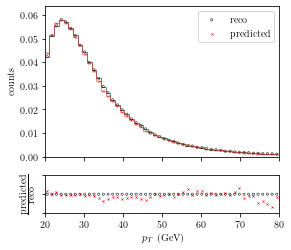

<Figure size 432x288 with 0 Axes>

In [19]:
target = "RecoDatapT"
source = FIELDS[target]
features = source["inputs"]
print("Training Features:\n", features)
print("\nTarget = ", target)
PREVIOUS_AUTOREGRESSIVE_DIST_NAME = "AUTOREGRESSIVE_m_Prime.csv"
AUTOREGRESSIVE_DIST_NAME = "AUTOREGRESSIVE_m_Prime_pT_Prime.csv"
print("USING NEW DATASET\n")
######################################
USE_BRADEN_SCALING = False

########################################################################################

raw_train_data, raw_test_data, raw_valid_data = load_raw_data()


# Load scaled data
# scaled_train_data, scaled_test_data, scaled_valid_data = load_scaled_dataframes()


################################################## Load Evaluation Data
#eval_data=pd.read_csv(DATA_DIR+'/test_data_10M_2.csv')
# Or test on actual test (evaluation) data for development
# eval_data=pd.read_csv(DATA_DIR+'/test_data_10M_2.csv')

# Get targets and features
if USE_BRADEN_SCALING == True:
    print(f"spliting data for {target}")
    train_t, train_x = split_t_x(
        df=scaled_train_data, target=target, input_features=features
    )
    print("train_t shape = ", train_t.shape, "train_x shape = ", train_x.shape)
    print("\n Training features:\n")
    print(train_x)
    valid_t, valid_x = split_t_x(
        df=scaled_valid_data, target=target, input_features=features
    )
    print("valid_t shape = ", valid_t.shape, "valid_x shape = ", valid_x.shape)
        
    ##### WHAT MATTERS IS TEST (EVALUATION)

    test_t, test_x = split_t_x(
        df=scaled_test_data, target=target, input_features=features
    )
    print("test_t shape = ", test_t.shape, "test_x shape = ", test_x.shape)

else:
    print(f"spliting autoregressive evaluation data for {target}")
    train_t, train_x = normal_split_t_x(
            df=raw_train_data, target=target, input_features=features
        )
    print("train_t shape = ", train_t.shape, "train_x shape = ", train_x.shape)
    print("\n Training features:\n")
    print(train_x)
    valid_t, valid_x = normal_split_t_x(
        df=raw_valid_data, target=target, input_features=features
    )
    print("valid_t shape = ", valid_t.shape, "valid_x shape = ", valid_x.shape)
    ##### WHAT MATTERS IS TEST (EVALUATION)
    test_t, test_x = normal_split_t_x(
        df=raw_test_data, target=target, input_features=features
    )
    print("test_t shape = ", test_t.shape, "test_x shape = ", test_x.shape)

print("no need to train_test_split since we already have the split dataframes")
print(valid_x.mean(axis=0), valid_x.std(axis=0))
print(train_x.mean(axis=0), train_x.std(axis=0))
print(valid_t.mean(), valid_t.std())
print(train_t.mean(), train_t.std())
######################################################
# Replace test_x with eval_data

# ev_features = features
# eval_data_df = eval_data[ev_features]
# eval_data = np.array(eval_data_df)
# test_x = eval_data

# eval_data=pd.read_csv(DATA_DIR+'/test_data_10M_2.csv')
    
# eval_data=raw_train_data[:raw_test_data.shape[0]]
# test_x = np.array

# Apply z scaling to features and targets
# to features

NFEATURES = train_x.shape[1]
# GET EVALUATION DATASET
# eval_data= get_previous_autoregressive_dist(AUTOREGRESSIVE_DIST_NAME=PREVIOUS_AUTOREGRESSIVE_DIST_NAME)
# test_x = np.array(eval_data[features])



TRAIN_SCALE_DICT = get_train_scale_dict(USE_BRADEN_SCALING)
# to features
apply_z_generator = apply_z_to_features(TRAIN_SCALE_DICT, train_x, test_x, valid_x)
train_x_z_scaled = next(apply_z_generator)
test_x_z_scaled = next(apply_z_generator)
valid_x_z_scaled = next(apply_z_generator)
print(valid_x_z_scaled.mean(axis=0), valid_x_z_scaled.std(axis=0))
print(train_x_z_scaled.mean(axis=0), train_x_z_scaled.std(axis=0))
# to targets
apply_z_to_targets_generator = apply_z_to_targets(train_t, test_t, valid_t)
train_t_z_scaled = next(apply_z_to_targets_generator)
test_t_z_scaled = next(apply_z_to_targets_generator)
valid_t_z_scaled = next(apply_z_to_targets_generator)
print(valid_t_z_scaled.mean(), valid_t_z_scaled.std())
print(train_t_z_scaled.mean(), train_t_z_scaled.std())

###########################################################
# Get the  parameters for this model and training
PARAMS_pT =  {
"n_layers": int(4),
"hidden_size": int(6),
"dropout_1": float(0.6),
"dropout_2": float(0.1),
"activation": "LeakyReLU",
    'optimizer_name':'Adam',
    'starting_learning_rate':float(1e-2),
    'momentum':float(0.6),
    'batch_size':int(1024),
    'n_iterations': int(5e5),
}

optimizer_name = PARAMS_pT["optimizer_name"]
print(type(optimizer_name))
# optimizer_name = BEST_PARAMS["optimizer_name"].to_string().split()[1]
NITERATIONS = PARAMS_pT["n_iterations"]
BATCHSIZE = PARAMS_pT["batch_size"]
comment = ""

# N_epochs X N_train_examples = N_iterations X batch_size
N_epochs = (NITERATIONS * BATCHSIZE) / int(train_x.shape[0])
print(
    f"This model was trained for {NITERATIONS} iteration, which is  {N_epochs} epochs"
)


filename_model = utils.get_model_filename(target, PARAMS_pT)
# filename_model = 'Trained_IQNx4_RecoDatapT_ 13_layer6_hiddenLeakyReLU_activation1024_batchsize200_Kiteration.dict'
# filename_model = 'Trained_IQNx4_RecoDatapT_10_layer6_hiddenLeakyReLU_activation512_batchsize300_Kiteration.dict'
trained_models_dir = "trained_models"
utils.mkdir(trained_models_dir)
# on cluster, Im using another TRAIN directory
PATH_model = os.path.join(
    IQN_BASE,  # the loaction of the repo
    "JupyterBook",  # up tp TRAIN could be combined in a srs dicretory
    "Cluster",
    "TRAIN",
    trained_models_dir,  # /trained_models
    filename_model,  # utils.get_model_filename has the saved file format
)

# Load trained model
IQN_pT = load_model(PATH_model, PARAMS_pT)
# Get predicted distribution
p = simple_eval(IQN_pT, test_x_z_scaled)

range_ = (FIELDS[target]["xmin"], FIELDS[target]["xmax"])
bins = 50
REAL_RAW_DATA = raw_test_data

YLIM = (0.8, 1.2)
###########GET REAL DIST###########
REAL_RAW_DATA = REAL_RAW_DATA[
    ["RecoDatapT", "RecoDataeta", "RecoDataphi", "RecoDatam"]
]
REAL_RAW_DATA.columns = ["realpT", "realeta", "realphi", "realm"]
REAL_DIST = REAL_RAW_DATA["realpT"]
norm_data = REAL_RAW_DATA.shape[0]
#############GET EVALUATION DIST#############
raw_test_data.describe()
pT_reco = raw_test_data["RecoDatapT"]
pT_gen = raw_test_data["genDatapT"]
# plt.hist(m_reco,label=r'$m_{gen}^{test \ data}$');plt.legend();plt.show()

def descale_Braden_scaled_prediction(label, p):
    """Label could be m. p is the outcome of the model evaluation, e.g. 
    IQN_m = load_model(PATH_model, PARAMS_m)
    p = simple_eval(IQN_m, test_x_z_scaled)

    """
    # make sure you've set braden scaling global variable to use this function.
    assert USE_BRADEN_SCALING==True
    orig_ratio = T(label, scaled_df=scaled_train_data)
    z_inv_f = z_inverse(xprime=p, mean=np.mean(orig_ratio), std=np.std(orig_ratio))
    L_obs = L(orig_observable=pT_gen, label=label)
    z_inv_f = z_inv_f.flatten()
    print(z_inv_f.shape)

    factor = (z_inv_f * (L_obs + 10)) - 10
    label_pred = L_inverse(L_observable=factor, label=label)
    return label_pred


pT_pred = z_inverse2(
    xprime=p,
    train_mean=TRAIN_SCALE_DICT[target]["mean"],
    train_std=TRAIN_SCALE_DICT[target]["std"],
)
pT_pred = pT_pred.flatten()

# Get histogram of predicted distribution
real_label_counts_pT, predicted_label_counts_pT, label_edges_pT = get_hist_simple(
    predicted_dist=pT_pred, target=target
)

# Get evaluation data as test data for development

eval_data_df=pd.read_csv(DATA_DIR+'/test_data_10M_2.csv')#[features]




new_cols = ["RecoDatam", target] + X
eval_data_df = eval_data_df.reindex(columns=new_cols)
print("EVALUATION DATA NEW INDEX\n", eval_data_df.head())
# save 
eval_data_df.to_csv(
    os.path.join(
        IQN_BASE, "JupyterBook", "Cluster", "EVALUATE", AUTOREGRESSIVE_DIST_NAME
    )
)

# Load this saved predited autoregressive distribution
AUTOREGRESSIVE_DIST = pd.read_csv(
    os.path.join(
        IQN_BASE, "JupyterBook", "Cluster", "EVALUATE", AUTOREGRESSIVE_DIST_NAME
    )
)

# norm_IQN=AUTOREGRESSIVE_DIST.shape[0]
# get normalization values
norm_autoregressive = AUTOREGRESSIVE_DIST.shape[0]
norm_IQN = norm_autoregressive
print(
    "norm_data",
    norm_data,
    "\nnorm IQN",
    norm_IQN,
    "\nnorm_autoregressive",
    norm_autoregressive,
)

# Finally, plot predicted distribution
plot_one(
    target=target,
    real_edges=label_edges_pT,
    real_counts=real_label_counts_pT,
    predicted_counts=predicted_label_counts_pT,
    save_plot=True,
    PARAMS=PARAMS_pT,
)
